In [773]:
import pandas as pd
import pandas_datareader as pdr
import datetime
import yfinance as yf
import numpy as np
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
import matplotlib.pyplot as plt
import xlrd
from featexp import get_univariate_plots
from joblib import dump, load
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from matplotlib import pyplot
from numpy import sort
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import copy
from sklearn.model_selection import cross_validate

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

pd.options.mode.chained_assignment = None
np.set_printoptions(suppress=True)

#FEATURES
#Prediction? Number of days trending upwards? Percentage increase?
#Sell after a 5% increase?
#Dissect what all of this means.
#I want to get a precision / recall curve
#Set rounding threshold lower
#Confidence variables?
#Try other models?
#Try other stocks besides stocks that tend to just go up?
#Predict rise in values rather than just simple classification?
#Set rise rate higher / faster?
#Invest money based on confidence / probability?
#We call more about precision & accuracy than recall
#Remove unnecessary features, prevent overfitting?
#Paper trade over previous data...see how we would have fared?
#Automate all of this?
#NaN values a problem?
#Overfitting based on general bullish tech stocks?
#Rise 5% within 10 days or AT 10 days?
#get model size / kernel size


#TODOS
#Get all functions working spectacularly
#Normalize MACD?
#check calculations. RSI in particular. 9 or 10 days?
#early stopping setting? Overfitting?
#Try different model? cat one?
#Change train, test, validate to 2 yrs, 1 yr, 1yr w/ SPY
#time how long it takes, get size metrics
#what should a good rounding threshold actually be?
#logloss / auc? what metric to go by?

In [774]:
def RSI_calc(start, lookback, df, date_time=True): #Calculate RSI for a given day
        if date_time:
            start = start.strftime("%Y-%m-%d")
        if ((df.index[df["DATE"]==start][0])-lookback) < 0:
            return None
        df = df[(df.index[df["DATE"]==start][0])-lookback:df.index[df["DATE"]==start][0]]
        
        df['GAIN_LOSS'] = df.apply(lambda row : (row["CLOSE"]-row["OPEN"]) / row["OPEN"] * 100, axis=1)
        avg_gain = df.loc[df['GAIN_LOSS'] >= 0]["GAIN_LOSS"].mean()
        avg_loss = df.loc[df['GAIN_LOSS'] < 0]["GAIN_LOSS"].mean() * -1
        RSI = 100 - (100 / (1 + (avg_gain/avg_loss)))
        return RSI

In [775]:
def daily_return(start, lookback, df, date_time=True): #Calculate daily return
        if date_time:
            start = start.strftime("%Y-%m-%d")
        if ((df.index[df["DATE"]==start][0])-lookback) < 0:
            return None
        df = df[(df.index[df["DATE"]==start][0])-lookback:df.index[df["DATE"]==start][0]+1] #Include day?
        df['daily_change'] = df.apply(lambda row: ((row['CLOSE'] - row['OPEN']) / row['OPEN']) * 100, axis=1)
        avg_daily_return = df['daily_change'].mean()
        return avg_daily_return

In [776]:
def weekly_return(start, lookback, df, date_time=True): #Calculate weekly return
        if date_time:
            start = start.strftime("%Y-%m-%d")
        if ((df.index[df["DATE"]==start][0])-lookback) < 0:
            return None
        df = df[(df.index[df["DATE"]==start][0])-lookback:df.index[df["DATE"]==start][0]+1] #Include day?
        df = df.iloc[::5, :]
        df = df.reset_index()
        weekly_change_sum = 0
        for i in range(1, len(df)): #Would really like to not be hacky about this...but oh well
            weekly_change_sum += ((df.iloc[i]['CLOSE'] - df.iloc[i-1]['CLOSE']) / df.iloc[i-1]['OPEN']) * 100
        weekly_change_avg = weekly_change_sum / len(df)-1
        return weekly_change_avg

In [777]:
def monthly_return(start, lookback, df, date_time=True): #Calculate monthly return
        if date_time:
            start = start.strftime("%Y-%m-%d")
        if ((df.index[df["DATE"]==start][0])-lookback) < 0:
            return None
        if(lookback < 30):
            return None
        df = df[(df.index[df["DATE"]==start][0])-lookback:df.index[df["DATE"]==start][0]+1] #Include day?
        df = df.iloc[::30, :]
        df = df.reset_index()
        monthly_change_sum = 0
        for i in range(1, len(df)): #Would really like to not be hacky about this...but oh well
            monthly_change_sum += ((df.iloc[i]['CLOSE'] - df.iloc[i-1]['CLOSE']) / df.iloc[i-1]['OPEN']) * 100
        monthly_change_avg = monthly_change_sum / len(df)-1
        return monthly_change_avg

In [778]:
def EMA(start, lookback, df): #Calculate MACD w/ appropriate subcalculations
        df = df[(df.index[df["DATE"]==start][0])-lookback:df.index[df["DATE"]==start][0]+1]
        df = df.reset_index()
        SMA = (df['CLOSE'][0:lookback-1].sum()) / lookback
        k = 2 / (lookback + 1)
        EMA = (df.loc[df['DATE']==start]['CLOSE'] * k) + (SMA * (1-k))
        return EMA
    
def MACD(start, lookback1, lookback2, df, date_time=True):
        if date_time:
            start = start.strftime("%Y-%m-%d")
        if ((df.index[df["DATE"]==start][0])-lookback2) < 0:
            return None
        EMA_short = EMA(start, lookback1, df)
        EMA_long = EMA(start, lookback2, df)
        return float(EMA_short) - float(EMA_long)

In [779]:
def ratio_avg_to_close(start, lookback, df, date_time=True): #Calc ratios
        if date_time:
            start = start.strftime("%Y-%m-%d")
        if ((df.index[df["DATE"]==start][0])-lookback) < 0:
            return None
        df = df[(df.index[df["DATE"]==start][0])-lookback:df.index[df["DATE"]==start][0]+1]
        df = df.reset_index()
        mean_close = df[0:lookback]['CLOSE'].sum() / lookback
        ratio = mean_close / df.iloc[lookback]['CLOSE']
        return ratio

In [780]:
def target(start, look_forward, df, target, date_time=True): #Calculate target @ # of days
        if date_time:
            start = start.strftime("%Y-%m-%d")
        if ((df.index[df["DATE"]==start][0])+look_forward) > len(df):
            return None
        df = df[(df.index[df["DATE"]==start][0]):df.index[df["DATE"]==start][0]+look_forward] #+1? 9 or 10 days?
        df = df.reset_index()
        percent_increase = (df.iloc[look_forward-1]['CLOSE'] - df.iloc[0]['CLOSE']) / df.iloc[0]['CLOSE'] * 100
        if percent_increase >= target:
            return True
        else:
            return False

In [781]:
def calcutron(stock_data, stock_symbols, csv_export, csv_name, percent_increase, days_increase): #All the calculations
    df_list = []
    for stock in stock_symbols:
        df = stock_data.loc[stock_data["TICKER"]==stock]
        for num in [5,10,30,60]:
            df['RSI ' + str(num)] = df.apply(lambda row: RSI_calc(row['DATE'], num, df, True), axis=1)
            df["AVG DAILY RETURN " + str(num)] = df.apply(lambda row: daily_return(row['DATE'], num, df, True), axis=1)
            df["AVG WEEKLY RETURN " + str(num)] = df.apply(lambda row: weekly_return(row['DATE'], num, df, True), axis=1)
            df["AVG MONTHLY RETURN " + str(num)] = df.apply(lambda row: monthly_return(row['DATE'], num, df, True), axis=1)
            df["RATIO " + str(num)] = df.apply(lambda row: ratio_avg_to_close(row['DATE'], num, df, True), axis=1)
        df["MACD 10_30"] = df.apply(lambda row: MACD(row['DATE'], 10, 30, df, True), axis=1)
        df["MACD 5_10"] = df.apply(lambda row: MACD(row['DATE'], 5, 10, df, True), axis=1)
        df["MACD 2_10"] = df.apply(lambda row: MACD(row['DATE'], 2, 10, df, True), axis=1)
        df['MACD 10_30 DIFF'] = df['MACD 10_30'].diff()
        df['MACD 5_10 DIFF'] = df['MACD 5_10'].diff()
        df['MACD 2_10 DIFF'] = df['MACD 2_10'].diff()
        df["TARGET"] = df.apply(lambda row: target(row['DATE'], days_increase, df, percent_increase, True), axis=1)
        df_list.append(df)
    stock_data = pd.concat(df_list)
    stock_data['TARGET'].value_counts(normalize=True) * 100
    if csv_export:
        stock_data.to_excel(csv_name)
    return stock_data

In [782]:
def just_stock_data_within(train_stocks, export_csv, csv_name, days, percent_increase, days_increase):
    stock_data = pd.DataFrame(columns=["Ticker","Date","Open","High","Low","Close"])
    for stock in train_stocks:
        y_finance_data = yf.Ticker(stock).history(start=(datetime.date.today()-datetime.timedelta(days=days)).strftime("%Y-%m-%d")).reset_index()
        y_finance_data.insert(0,"Ticker", stock)
        y_finance_data = y_finance_data[['Ticker', 'Date','Open','High','Low','Close']]
        stock_data = pd.concat([stock_data, y_finance_data])
    stock_data = stock_data.rename(columns={"Ticker":"TICKER", "Date":"DATE", "Open":"OPEN", "High":"HIGH", "Low":"LOW", "Close":"CLOSE"})
    stock_data = calcutron_within(stock_data, train_stocks, export_csv, csv_name, percent_increase, days_increase)

    stock_data = stock_data.drop(['AVG MONTHLY RETURN 5','AVG MONTHLY RETURN 10'], axis=1)
    stock_data = stock_data.dropna()

    input_patterns = stock_data[features][60:len(stock_data)-10]
    input_label = stock_data['TARGET'][60:len(stock_data)-10].astype(int) #Why are these floats? It bothers me.
    return stock_data, input_patterns, input_label

In [783]:
def just_stock_data(train_stocks, export_csv, csv_name, days, percent_increase, days_increase):
    stock_data = pd.DataFrame(columns=["Ticker","Date","Open","High","Low","Close"])
    for stock in train_stocks:
        y_finance_data = yf.Ticker(stock).history(start=(datetime.date.today()-datetime.timedelta(days=days)).strftime("%Y-%m-%d")).reset_index()
        y_finance_data.insert(0,"Ticker", stock)
        y_finance_data = y_finance_data[['Ticker', 'Date','Open','High','Low','Close']]
        stock_data = pd.concat([stock_data, y_finance_data])
    stock_data = stock_data.rename(columns={"Ticker":"TICKER", "Date":"DATE", "Open":"OPEN", "High":"HIGH", "Low":"LOW", "Close":"CLOSE"})
    stock_data = calcutron(stock_data, train_stocks, export_csv, csv_name, percent_increase, days_increase)

    stock_data = stock_data.drop(['AVG MONTHLY RETURN 5','AVG MONTHLY RETURN 10'], axis=1)
    stock_data = stock_data.dropna()

    input_patterns = stock_data[features][60:len(stock_data)-10]
    input_label = stock_data['TARGET'][60:len(stock_data)-10].astype(int) #Why are these floats? It bothers me.
    return stock_data, input_patterns, input_label

In [784]:
#Create base model, read from CSV if we have one, perfrom 100 metric trials
def model_creation(train_stocks, test_size, read_csv, export_csv, csv_name, days, percent_increase, days_increase, features=None, prints=False):
    if read_csv:
        stock_data = pd.read_excel(csv_name, engine='openpyxl')
    else:
        stock_data = pd.DataFrame(columns=["Ticker","Date","Open","High","Low","Close"])
        for stock in train_stocks:
            y_finance_data = yf.Ticker(stock).history(start=(datetime.date.today()-datetime.timedelta(days=days)).strftime("%Y-%m-%d")).reset_index()
            y_finance_data.insert(0,"Ticker", stock)
            y_finance_data = y_finance_data[['Ticker', 'Date','Open','High','Low','Close']]
            stock_data = pd.concat([stock_data, y_finance_data])
        stock_data = stock_data.rename(columns={"Ticker":"TICKER", "Date":"DATE", "Open":"OPEN", "High":"HIGH", "Low":"LOW", "Close":"CLOSE"})
        stock_data = calcutron(stock_data, train_stocks, export_csv, csv_name, percent_increase, days_increase)

    stock_data = stock_data.drop(['AVG MONTHLY RETURN 5','AVG MONTHLY RETURN 10'], axis=1)
    stock_data = stock_data.dropna()
    print(stock_data)
    if features == None:
        input_patterns = stock_data.loc[:,'RSI 5':'MACD 2_10 DIFF'][60:len(stock_data)-10]
    else:
        input_patterns = stock_data[features][60:len(stock_data)-10]
    
    input_label = stock_data['TARGET'][60:len(stock_data)-10].astype(int) #Why are these floats? It bothers me.
    if prints:
        print(input_patterns)
        print(stock_data['TARGET'].value_counts(normalize=True) * 100)
    
    accuracy_trials = []
    recall_trials = []
    precision_trials = []
    auc_trials = []

    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(input_patterns, input_label, test_size = test_size)
        model = XGBClassifier(eval_metric="auc", use_label_encoder=False)
        model.fit(X_train, y_train)
        accuracy_trials.append(accuracy_score(y_test, model.predict(X_test)) * 100.0)
        precision_trials.append(precision_score(y_test, model.predict(X_test)) * 100.0)
        recall_trials.append(recall_score(y_test, model.predict(X_test)) * 100.0)
        average_precision_trials.append(average_precision_score(y_test, model.predict(X_test)))
        auc_trials.append(roc_auc_score(y_test, model.predict(X_test)))

    mean_accuracy = sum(accuracy_trials) / len(accuracy_trials)
    mean_precision = sum(precision_trials) / len(precision_trials)
    mean_recall= sum(recall_trials) / len(recall_trials)
    mean_auc = sum(auc_trials) / len(auc_trials)

    if prints:
        print("Validation Trial")
        print("Mean Accuracy: {}%".format(mean_accuracy))
        print("Mean Precision: {}%".format(mean_precision))
        print("Mean Recall: {}%".format(mean_recall))
        print("Mean AUC: {}%".format(mean_auc))
        print(model)
    return model, stock_data, X_train, X_test, y_train, y_test

In [785]:
#Perform testing trials on given stock
def trials(model, threshold, test_stocks, days, export_csv, csv_name, percent_increase, days_increase, features, prints=False):
    #Add ability to read from CSV here?
    for stock in test_stocks:
        print(stock)
        stock_data_testing = pd.DataFrame(columns=["Ticker","Date","Open","High","Low","Close"])
        y_finance_data = yf.Ticker(stock).history(start=(datetime.date.today()-datetime.timedelta(days=days)).strftime("%Y-%m-%d")).reset_index()
        y_finance_data.insert(0,"Ticker", stock)
        y_finance_data = y_finance_data[['Ticker', 'Date','Open','High','Low','Close']]

        stock_data_testing = pd.concat([stock_data_testing, y_finance_data])
        stock_data_testing = stock_data_testing.rename(columns={"Ticker":"TICKER", "Date":"DATE", "Open":"OPEN", "High":"HIGH", "Low":"LOW", "Close":"CLOSE"})
        stock_data_testing = calcutron(stock_data_testing, [stock], False, None, percent_increase, days_increase)
        stock_data_testing = stock_data_testing.drop(['AVG MONTHLY RETURN 5','AVG MONTHLY RETURN 10'], axis=1)
        stock_data_testing = stock_data_testing.dropna()
        if features == None:
            input_patterns_testing = stock_data_testing.loc[:,'RSI 5':'MACD 2_10 DIFF'][60:len(stock_data)-10]
        else:
            input_patterns_testing = stock_data_testing[features][60:len(stock_data)-10]
    
        input_label_testing = stock_data_testing['TARGET'][60:len(stock_data)-10].astype(int)
        print(input_patterns_testing)
        #if prints:
            #print(stock_data_testing)
            #print(input_patterns_testing)
            #print(input_label_testing)

        accuracy_trials_testing = []
        recall_trials_testing = []
        precision_trials_testing = []
        auc_trials_testing = []

        y_prob = model.predict_proba(input_patterns_testing)
        y_prob_round = []
        for row in y_prob:
            if row[1] > threshold:
                y_prob_round.append(1)
            else:
                y_prob_round.append(0)
        y_pred = model.predict(input_patterns_testing)
        
        accuracy_trials_testing.append(accuracy_score(input_label_testing, y_pred) * 100.0)
        precision_trials_testing.append(precision_score(input_label_testing, y_pred) * 100.0)
        recall_trials_testing.append(recall_score(input_label_testing, y_pred) * 100.0)
        auc_trials_testing.append(roc_auc_score(input_label_testing, y_pred) * 100)
        mean_accuracy_testing = sum(accuracy_trials_testing) / len(accuracy_trials_testing)
        mean_precision_testing = sum(precision_trials_testing) / len(precision_trials_testing)
        mean_recall_testing = sum(recall_trials_testing) / len(recall_trials_testing)
        mean_auc_testing = sum(auc_trials_testing) / len(auc_trials_testing)

        if prints:
            print(stock)
            print("Standard Threshold")
            print("Accuracy {}: {}%".format(stock, mean_accuracy_testing))
            print("Precision {}: {}%".format(stock, mean_precision_testing))
            print("Recall {}: {}%".format(stock, mean_recall_testing))
            print("AUC {}: {}%".format(stock, mean_auc_testing))
            print()
            
        accuracy_trials_testing = []
        recall_trials_testing = []
        precision_trials_testing = []
        auc_trials_testing = []

        accuracy_trials_testing.append(accuracy_score(input_label_testing, y_prob_round) * 100.0)
        precision_trials_testing.append(precision_score(input_label_testing, y_prob_round) * 100.0)
        recall_trials_testing.append(recall_score(input_label_testing, y_prob_round) * 100.0)
        auc_trials_testing.append(roc_auc_score(input_label_testing, y_pred) * 100)
        mean_accuracy_testing = sum(accuracy_trials_testing) / len(accuracy_trials_testing)
        mean_precision_testing = sum(precision_trials_testing) / len(precision_trials_testing)
        mean_recall_testing = sum(recall_trials_testing) / len(recall_trials_testing)
        mean_auc_testing = sum(auc_trials_testing) / len(auc_trials_testing)

        if prints:
            print("Rounding Threshold: {}".format(threshold))
            print("Accuracy {}: {}%".format(stock, mean_accuracy_testing))
            print("Precision {}: {}%".format(stock, mean_precision_testing))
            print("Recall {}: {}%".format(stock, mean_recall_testing))
            print("AUC {}: {}%".format(stock, mean_auc_testing))
            
    return stock_data

In [786]:
def target_within(start, look_forward, df, target, date_time=True): #New target function for within # of days instead of @
        if date_time:
            start = start.strftime("%Y-%m-%d")
        if ((df.index[df["DATE"]==start][0])+look_forward) > len(df):
            return None
        df = df[(df.index[df["DATE"]==start][0]):df.index[df["DATE"]==start][0]+look_forward+1] #+1? 9 or 10 days?
        df = df.reset_index()
        for i in range(1,len(df)):
            percent_increase = (df.iloc[i]['CLOSE'] - df.iloc[0]['CLOSE']) / df.iloc[0]['CLOSE'] * 100
            if percent_increase >= target:
                return True
        return False

def calcutron_within(stock_data, stock_symbols, csv_export, csv_name, percent_increase, days_increase): #Ditto as above
    df_list = []
    for stock in stock_symbols:
        df = stock_data.loc[stock_data["TICKER"]==stock]
        for num in [5,10,30,60]:
            df['RSI ' + str(num)] = df.apply(lambda row: RSI_calc(row['DATE'], num, df, True), axis=1)
            df["AVG DAILY RETURN " + str(num)] = df.apply(lambda row: daily_return(row['DATE'], num, df, True), axis=1)
            df["AVG WEEKLY RETURN " + str(num)] = df.apply(lambda row: weekly_return(row['DATE'], num, df, True), axis=1)
            df["AVG MONTHLY RETURN " + str(num)] = df.apply(lambda row: monthly_return(row['DATE'], num, df, True), axis=1)
            df["RATIO " + str(num)] = df.apply(lambda row: ratio_avg_to_close(row['DATE'], num, df, True), axis=1)
        df["MACD 10_30"] = df.apply(lambda row: MACD(row['DATE'], 10, 30, df, True), axis=1)
        df["MACD 5_10"] = df.apply(lambda row: MACD(row['DATE'], 5, 10, df, True), axis=1)
        df["MACD 2_10"] = df.apply(lambda row: MACD(row['DATE'], 2, 10, df, True), axis=1)
        df['MACD 10_30 DIFF'] = df['MACD 10_30'].diff()
        df['MACD 5_10 DIFF'] = df['MACD 5_10'].diff()
        df['MACD 2_10 DIFF'] = df['MACD 2_10'].diff()
        df["TARGET"] = df.apply(lambda row: target_within(row['DATE'], days_increase, df, percent_increase, True), axis=1)
        df_list.append(df)
    stock_data = pd.concat(df_list)
    stock_data['TARGET'].value_counts(normalize=True) * 100
    if csv_export:
        stock_data.to_excel(csv_name)
    return stock_data


def model_creation_within(train_stocks, test_size, read_csv, export_csv, csv_name, days, percent_increase, days_increase, features=None, prints=False):
    if read_csv:
        stock_data = pd.read_excel(csv_name, engine='openpyxl')
    else:
        stock_data = pd.DataFrame(columns=["Ticker","Date","Open","High","Low","Close"])
        for stock in train_stocks:
            y_finance_data = yf.Ticker(stock).history(start=(datetime.date.today()-datetime.timedelta(days=days)).strftime("%Y-%m-%d")).reset_index()
            y_finance_data.insert(0,"Ticker", stock)
            y_finance_data = y_finance_data[['Ticker', 'Date','Open','High','Low','Close']]
            stock_data = pd.concat([stock_data, y_finance_data])
        stock_data = stock_data.rename(columns={"Ticker":"TICKER", "Date":"DATE", "Open":"OPEN", "High":"HIGH", "Low":"LOW", "Close":"CLOSE"})
        stock_data = calcutron_within(stock_data, train_stocks, export_csv, csv_name, percent_increase, days_increase)

    stock_data = stock_data.drop(['AVG MONTHLY RETURN 5','AVG MONTHLY RETURN 10'], axis=1)
    stock_data = stock_data.dropna()
    print(stock_data)
    if features == None:
        input_patterns = stock_data.loc[:,'RSI 5':'MACD 2_10 DIFF'][60:len(stock_data)-10]
    else:
        input_patterns = stock_data[features][60:len(stock_data)-10]
    
    input_label = stock_data['TARGET'][60:len(stock_data)-10].astype(int) #Why are these floats? It bothers me.
    if prints:
        print(input_patterns)
        print(stock_data['TARGET'].value_counts(normalize=True) * 100)
    
    accuracy_trials = []
    recall_trials = []
    precision_trials = []
    auc_trials = []

    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(input_patterns, input_label, test_size = test_size)
        model = XGBClassifier(eval_metric="auc", use_label_encoder=False)
        model.fit(X_train, y_train)
        accuracy_trials.append(accuracy_score(y_test, model.predict(X_test)) * 100.0)
        precision_trials.append(precision_score(y_test, model.predict(X_test)) * 100.0)
        recall_trials.append(recall_score(y_test, model.predict(X_test)) * 100.0)
        #average_precision_trials.append(average_precision_score(y_test, model.predict(X_test)))
        auc_trials.append(roc_auc_score(y_test, model.predict(X_test)) * 100)

    mean_accuracy = sum(accuracy_trials) / len(accuracy_trials)
    mean_precision = sum(precision_trials) / len(precision_trials)
    mean_recall= sum(recall_trials) / len(recall_trials)
    mean_auc = sum(auc_trials) / len(auc_trials)

    if prints:
        print("Validation Trial")
        print("Mean Accuracy: {}%".format(mean_accuracy))
        print("Mean Precision: {}%".format(mean_precision))
        print("Mean Recall: {}%".format(mean_recall))
        print("Mean AUC: {}%".format(mean_auc))
        print(model)
    return model, stock_data, X_train, X_test, y_train, y_test

def trials_within(model, threshold, test_stocks, days, export_csv, csv_name, percent_increase, days_increase, features, prints=False):
    #Add ability to read from CSV here?
    for stock in test_stocks:
        print(stock)
        stock_data_testing = pd.DataFrame(columns=["Ticker","Date","Open","High","Low","Close"])
        y_finance_data = yf.Ticker(stock).history(start=(datetime.date.today()-datetime.timedelta(days=days)).strftime("%Y-%m-%d")).reset_index()
        y_finance_data.insert(0,"Ticker", stock)
        y_finance_data = y_finance_data[['Ticker', 'Date','Open','High','Low','Close']]

        stock_data_testing = pd.concat([stock_data_testing, y_finance_data])
        stock_data_testing = stock_data_testing.rename(columns={"Ticker":"TICKER", "Date":"DATE", "Open":"OPEN", "High":"HIGH", "Low":"LOW", "Close":"CLOSE"})
        stock_data_testing = calcutron_within(stock_data_testing, [stock], False, None, percent_increase, days_increase)
        stock_data_testing = stock_data_testing.drop(['AVG MONTHLY RETURN 5','AVG MONTHLY RETURN 10'], axis=1)
        stock_data_testing = stock_data_testing.dropna()
        if features == None:
            input_patterns_testing = stock_data_testing.loc[:,'RSI 5':'MACD 2_10 DIFF'][60:len(stock_data)-10]
        else:
            input_patterns_testing = stock_data_testing[features][60:len(stock_data)-10]
    
        input_label_testing = stock_data_testing['TARGET'][60:len(stock_data)-10].astype(int)
        print(input_patterns_testing)
        #if prints:
            #print(stock_data_testing)
            #print(input_patterns_testing)
            #print(input_label_testing)

        accuracy_trials_testing = []
        recall_trials_testing = []
        precision_trials_testing = []
        auc_trials_testing = []

        y_prob = model.predict_proba(input_patterns_testing)
        y_prob_round = []
        for row in y_prob:
            if row[1] > threshold:
                y_prob_round.append(1)
            else:
                y_prob_round.append(0)
        y_pred = model.predict(input_patterns_testing)
        
        accuracy_trials_testing.append(accuracy_score(input_label_testing, y_pred) * 100.0)
        precision_trials_testing.append(precision_score(input_label_testing, y_pred) * 100.0)
        recall_trials_testing.append(recall_score(input_label_testing, y_pred) * 100.0)
        auc_trials_testing.append(roc_auc_score(input_label_testing, y_pred) * 100)
        mean_accuracy_testing = sum(accuracy_trials_testing) / len(accuracy_trials_testing)
        mean_precision_testing = sum(precision_trials_testing) / len(precision_trials_testing)
        mean_recall_testing = sum(recall_trials_testing) / len(recall_trials_testing)
        mean_auc_testing = sum(auc_trials_testing) / len(auc_trials_testing)

        if prints:
            print(stock)
            print("Standard Threshold")
            print("Accuracy {}: {}%".format(stock, mean_accuracy_testing))
            print("Precision {}: {}%".format(stock, mean_precision_testing))
            print("Recall {}: {}%".format(stock, mean_recall_testing))
            print("AUC {}: {}%".format(stock, mean_auc_testing))
            print()
        
        accuracy_trials_testing = []
        recall_trials_testing = []
        precision_trials_testing = []
        auc_trials_testing = []

        accuracy_trials_testing.append(accuracy_score(input_label_testing, y_prob_round) * 100.0)
        precision_trials_testing.append(precision_score(input_label_testing, y_prob_round) * 100.0) #This is unnecessary lol
        recall_trials_testing.append(recall_score(input_label_testing, y_prob_round) * 100.0)
        auc_trials_testing.append(roc_auc_score(input_label_testing, y_pred) * 100)
        mean_accuracy_testing = sum(accuracy_trials_testing) / len(accuracy_trials_testing)
        mean_precision_testing = sum(precision_trials_testing) / len(precision_trials_testing)
        mean_recall_testing = sum(recall_trials_testing) / len(recall_trials_testing)
        mean_auc_testing = sum(auc_trials_testing) / len(auc_trials_testing)

        if prints:
            print("Rounding Threshold: {}".format(threshold))
            print("Accuracy {}: {}%".format(stock, mean_accuracy_testing))
            print("Precision {}: {}%".format(stock, mean_precision_testing))
            print("Recall {}: {}%".format(stock, mean_recall_testing))
            print("AUC {}: {}%".format(stock, mean_auc_testing))
            
    return stock_data

In [787]:
def relevant_features(model, X_train, y_train, X_test, y_test, threshold):
    model.fit(X_train, y_train)
    plot_importance(model)
    pyplot.show()
    
    thresholds = sort(model.feature_importances_) #Sort through and thresholding out the unnecessary features from above model
    for thresh in thresholds:
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        selection_model = XGBClassifier(use_label_encoder=False, eval_metric="auc")
        selection_model.fit(select_X_train, y_train)
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict(select_X_test)
        auc = roc_auc_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        print("Thresh=%.3f, n=%d, AUC: %.2f%%" % (thresh, select_X_train.shape[1], auc*100.0))
        print("Thresh=%.3f, n=%d, Precision: %.2f%%" % (thresh, select_X_train.shape[1], precision*100.0))
    
    print("-----------------ROUNDING THRESHOLD OF {}---------------------".format(threshold))
    
    thresholds = sort(model.feature_importances_) #Sort through and thresholding out the unnecessary features from above model
    for thresh in thresholds:
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        selection_model = XGBClassifier(use_label_encoder=False, eval_metric="auc")
        selection_model.fit(select_X_train, y_train)
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict_proba(select_X_test)
        y_prob_round = []
        for row in y_pred:
            if row[1] > threshold:
                y_prob_round.append(1)
            else:
                y_prob_round.append(0)
        y_pred = y_prob_round                          
        auc = roc_auc_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        print("Thresh=%.3f, n=%d, AUC: %.2f%%" % (thresh, select_X_train.shape[1], auc*100.0))
        print("Thresh=%.3f, n=%d, Precision: %.2f%%" % (thresh, select_X_train.shape[1], precision*100.0))

In [788]:
def hyper_parameter(model, X_train, y_train):
    #Hypertuning of parameters ala https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
    param_test1 = {
    'max_depth':range(9,11,1), #Room for tuning here
    'min_child_weight':range(1,3,1),
    'gamma':[i/10. for i in range(0,5)]
    }

    gsearch1 = GridSearchCV(estimator = model, param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsearch1.fit(X_train,y_train)
    print("TEST EVERYTHING")
    print("CV Results: ", gsearch1.cv_results_)
    print("Best Params: ", gsearch1.best_params_)
    print("Best Score: ", gsearch1.best_score_)
    return gsearch1.best_params_

In [789]:
def n_estimator(model, X_train, y_train):
    xgb_param = model.get_xgb_params()
    xgtrain = xgb.DMatrix(X_train, label=y_train)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=5, metrics='auc', early_stopping_rounds=50)
    print(cvresult)
    print("Ideal n_estimators: ", cvresult.shape[0])
    model.set_params(n_estimators=cvresult.shape[0])
    return model

(5142, 20)
STEP ONE DONE
BASELINE TRIAL
Mean Accuracy: 79.67640094711902%
Mean Precision: 73.98373983739837%
Mean Recall: 48.468708388814846%
Mean AUC: 70.64489822132849%
BASELINE TRIAL w/ THRESHOLDING
Mean Accuracy: 75.33543804262057%
Mean Precision: 84.23913043478272%
Mean Recall: 20.639147802929475%
Mean AUC: 59.5063377825639%
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, v

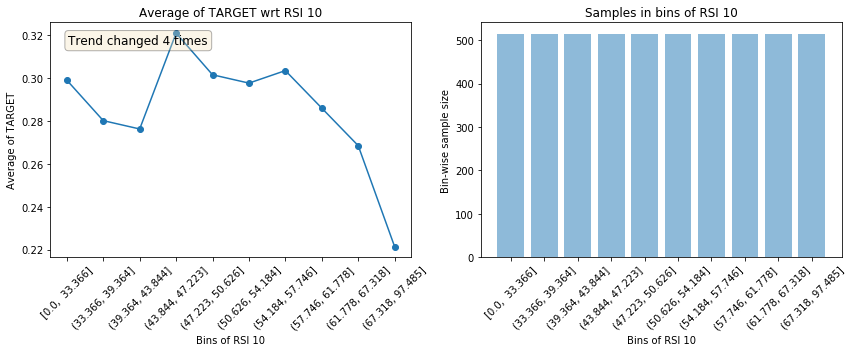

                                           Test data plots                                            


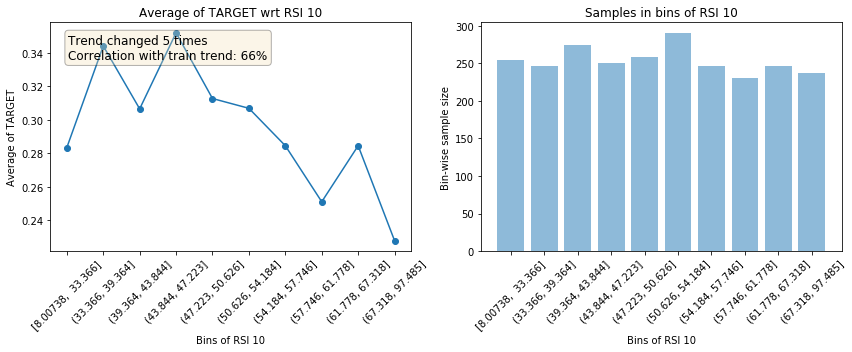

--------------------------------------------------------------------------------------------------------------


                                           Plots for RSI 30                                           
                                           Train data plots                                           


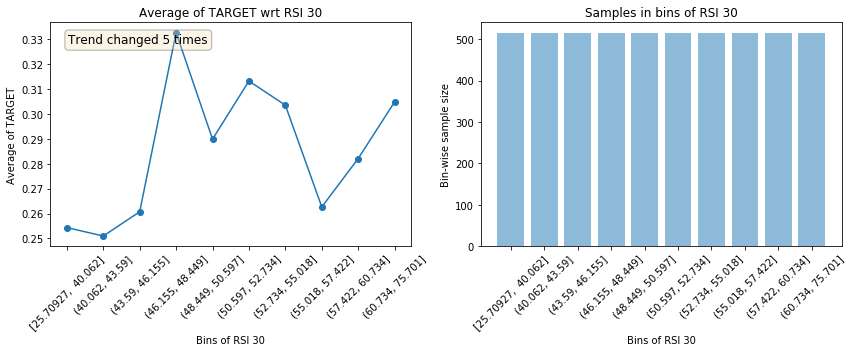

                                           Test data plots                                            


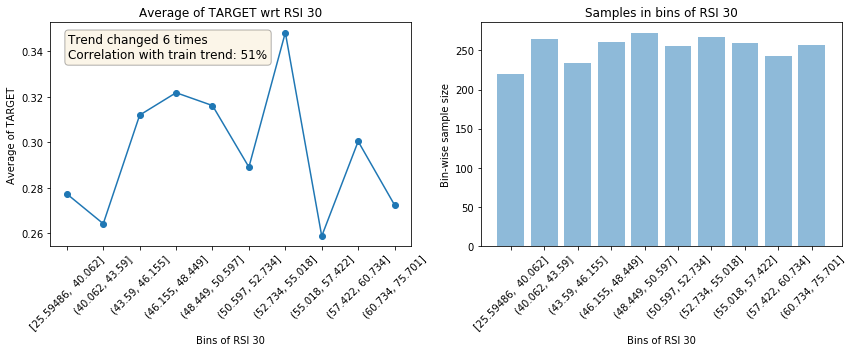

--------------------------------------------------------------------------------------------------------------


                                           Plots for RSI 60                                           
                                           Train data plots                                           


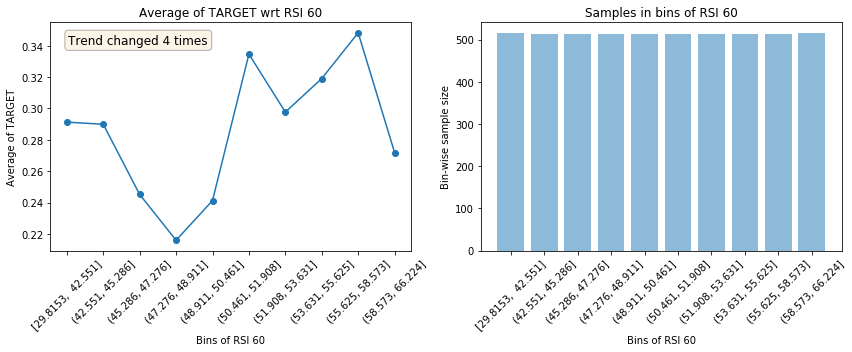

                                           Test data plots                                            


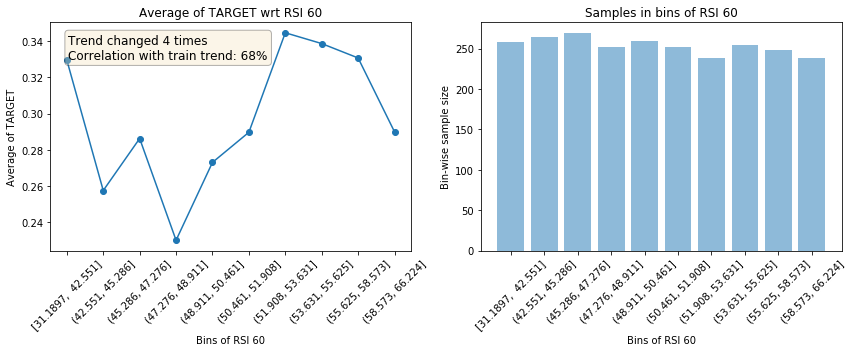

--------------------------------------------------------------------------------------------------------------


                                     Plots for AVG DAILY RETURN 5                                     
                                           Train data plots                                           


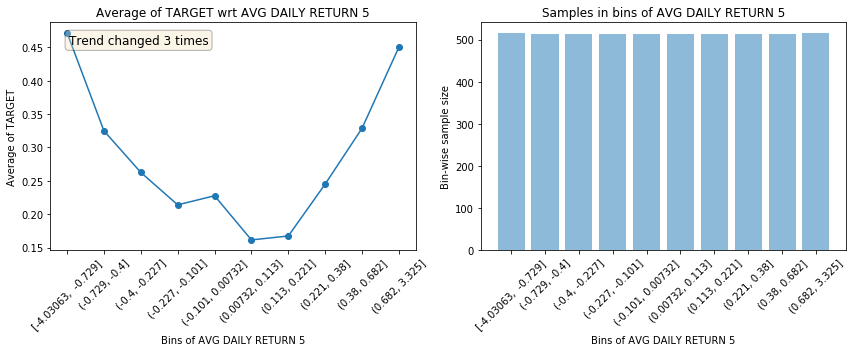

                                           Test data plots                                            


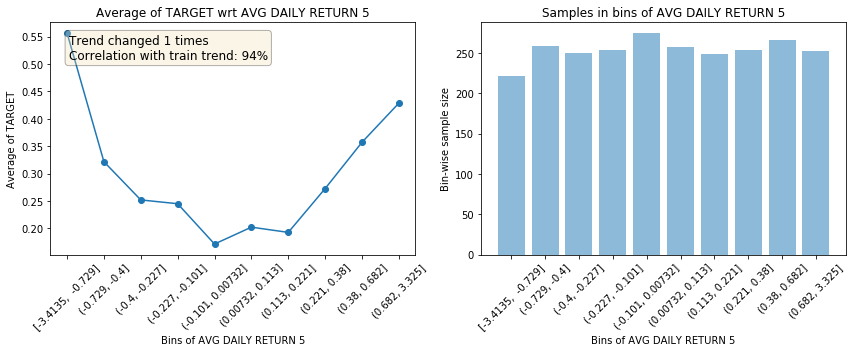

--------------------------------------------------------------------------------------------------------------


                                    Plots for AVG DAILY RETURN 10                                     
                                           Train data plots                                           


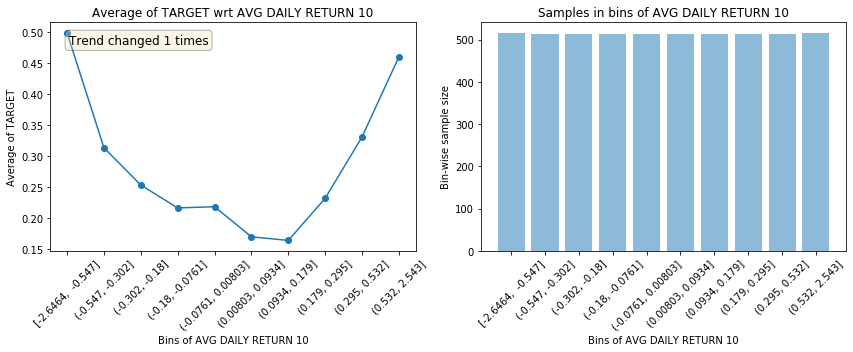

                                           Test data plots                                            


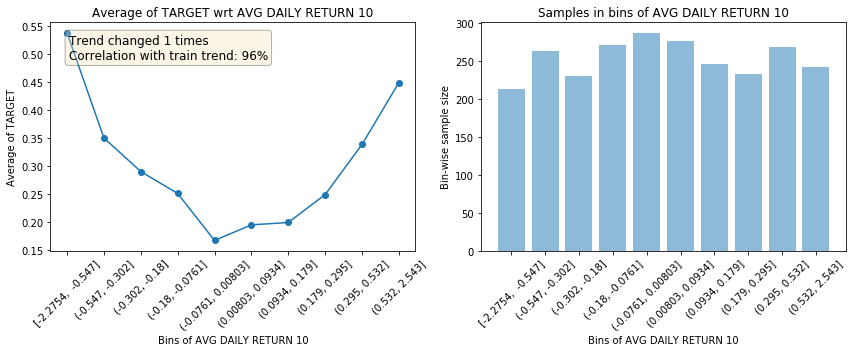

--------------------------------------------------------------------------------------------------------------


                                    Plots for AVG DAILY RETURN 30                                     
                                           Train data plots                                           


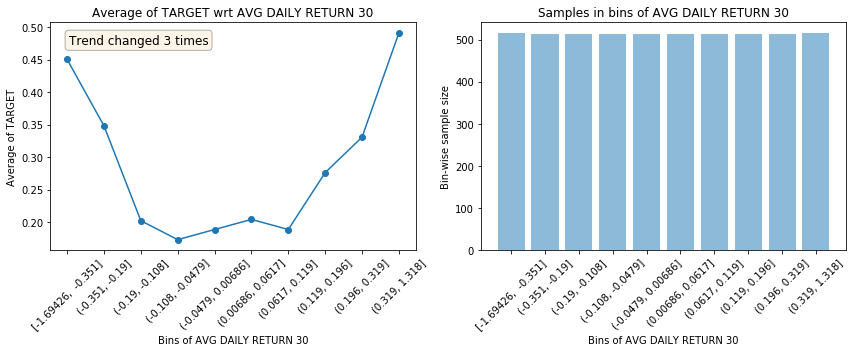

                                           Test data plots                                            


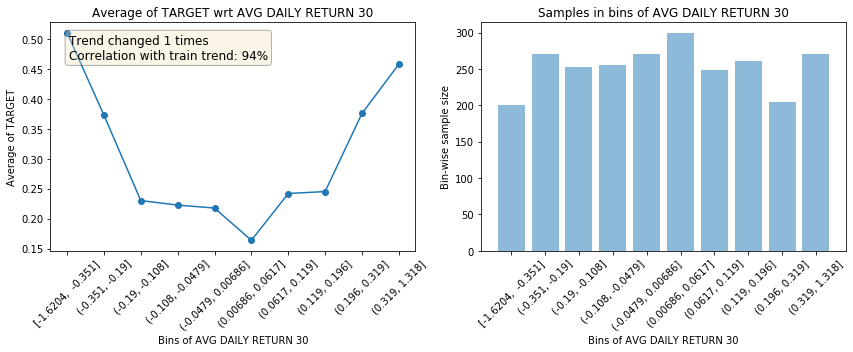

--------------------------------------------------------------------------------------------------------------


                                    Plots for AVG DAILY RETURN 60                                     
                                           Train data plots                                           


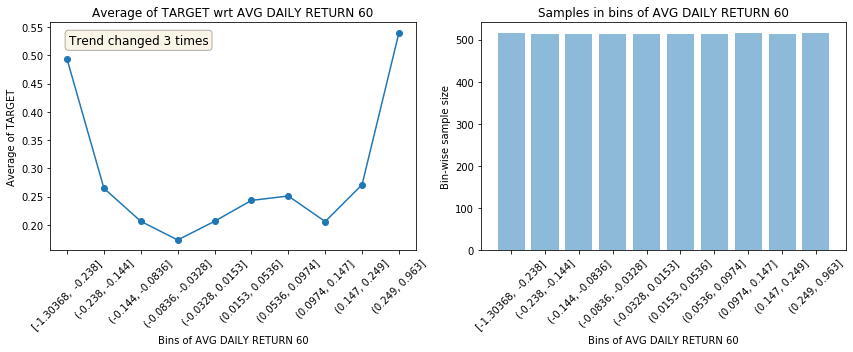

                                           Test data plots                                            


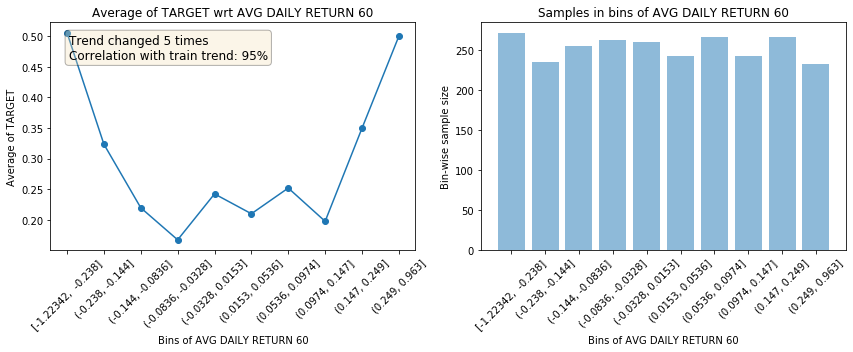

--------------------------------------------------------------------------------------------------------------


                                    Plots for AVG WEEKLY RETURN 5                                     
                                           Train data plots                                           


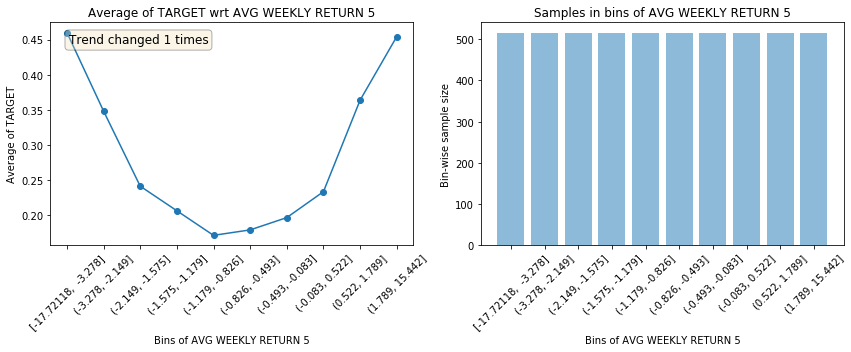

                                           Test data plots                                            


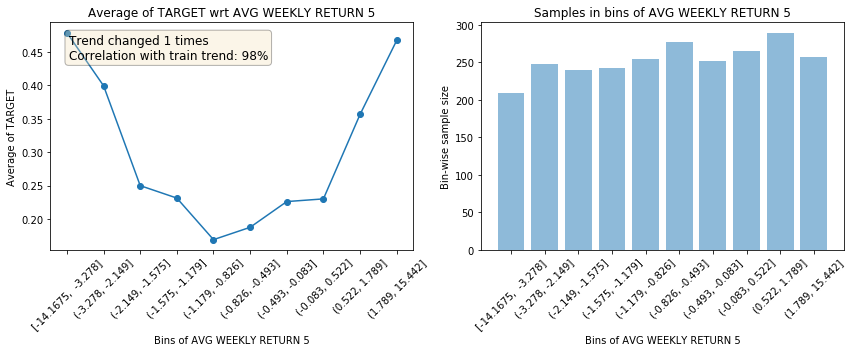

--------------------------------------------------------------------------------------------------------------


                                    Plots for AVG WEEKLY RETURN 10                                    
                                           Train data plots                                           


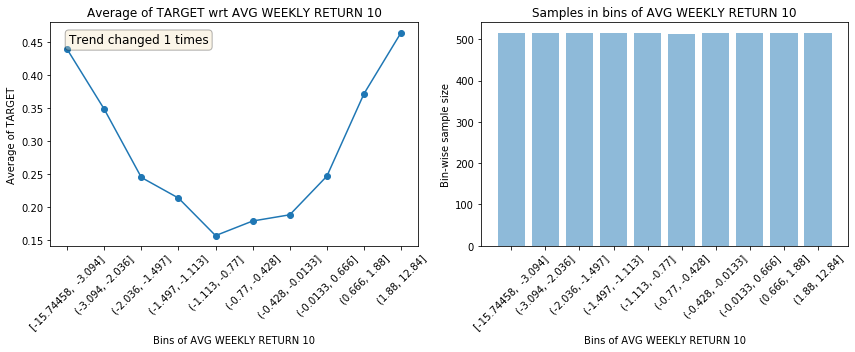

                                           Test data plots                                            


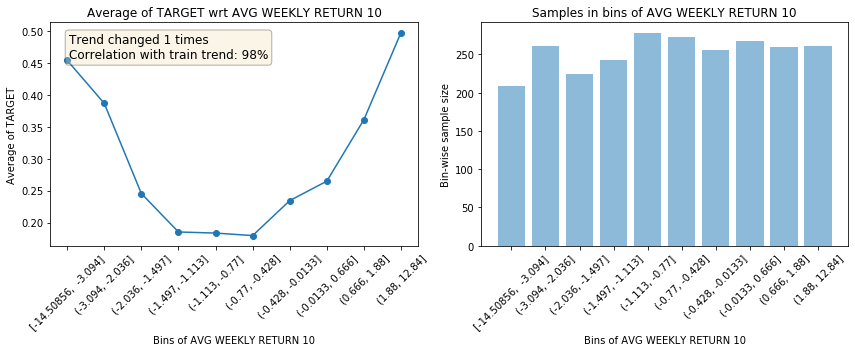

--------------------------------------------------------------------------------------------------------------


                                    Plots for AVG WEEKLY RETURN 30                                    
                                           Train data plots                                           


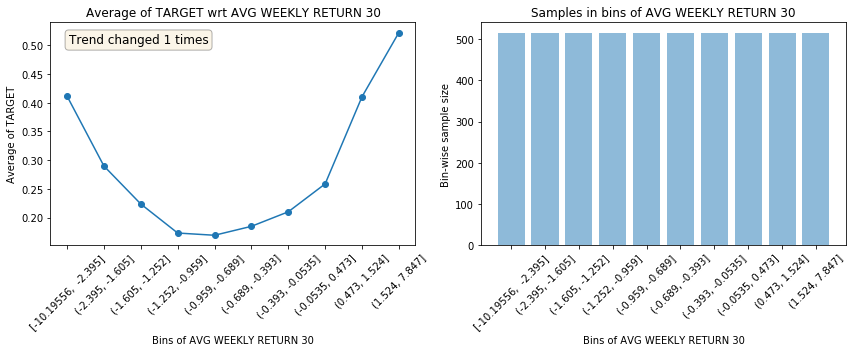

                                           Test data plots                                            


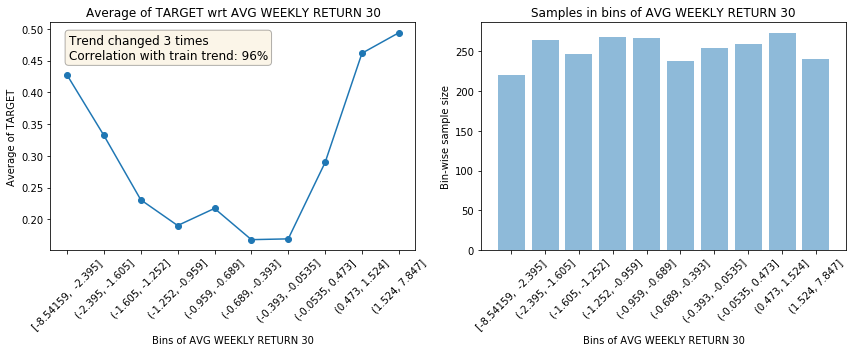

--------------------------------------------------------------------------------------------------------------


                                    Plots for AVG WEEKLY RETURN 60                                    
                                           Train data plots                                           


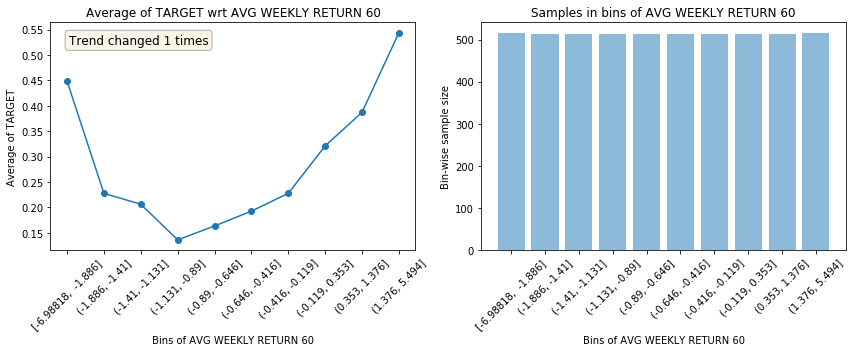

                                           Test data plots                                            


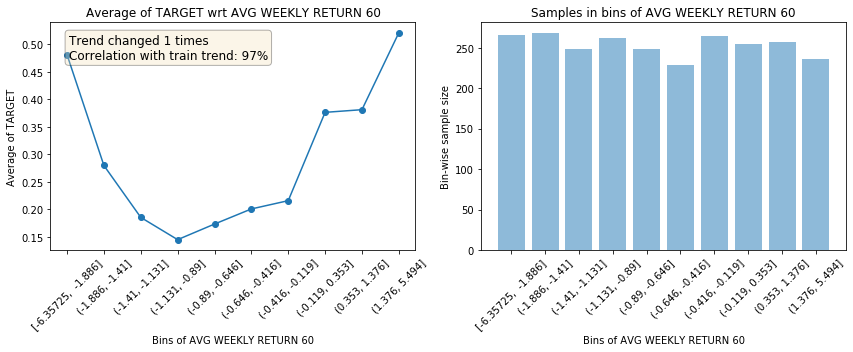

--------------------------------------------------------------------------------------------------------------


                                          Plots for RATIO 5                                           
                                           Train data plots                                           


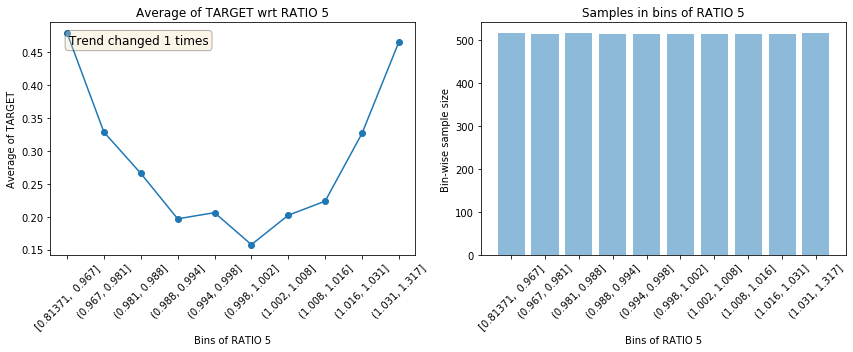

                                           Test data plots                                            


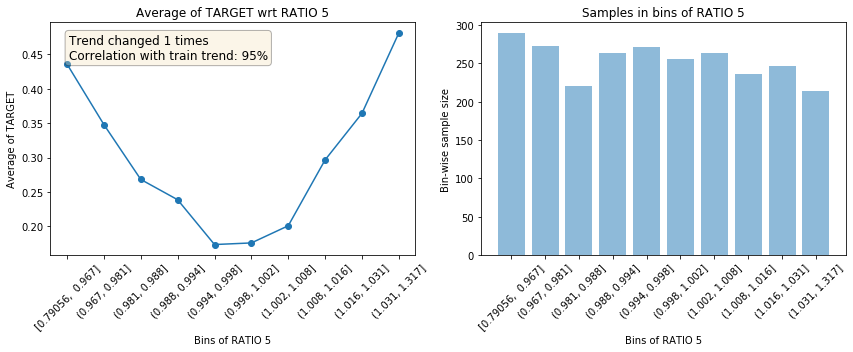

--------------------------------------------------------------------------------------------------------------


                                          Plots for RATIO 10                                          
                                           Train data plots                                           


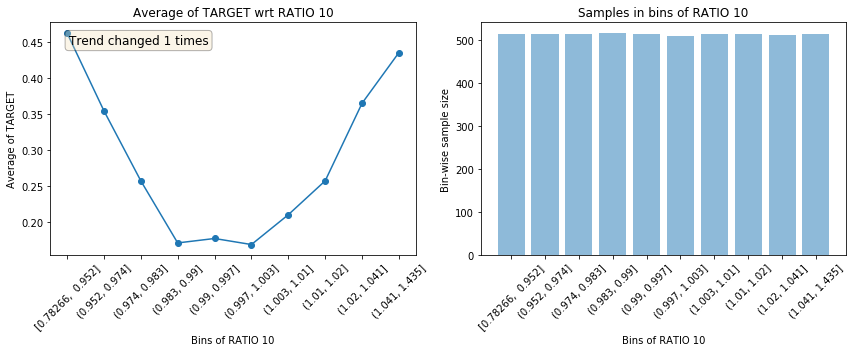

                                           Test data plots                                            


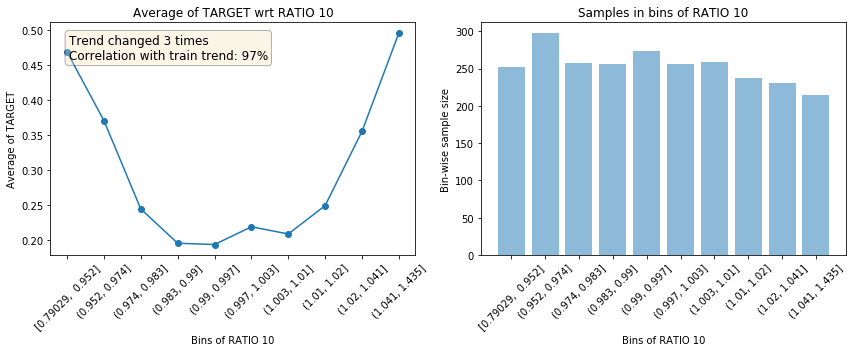

--------------------------------------------------------------------------------------------------------------


                                          Plots for RATIO 30                                          
                                           Train data plots                                           


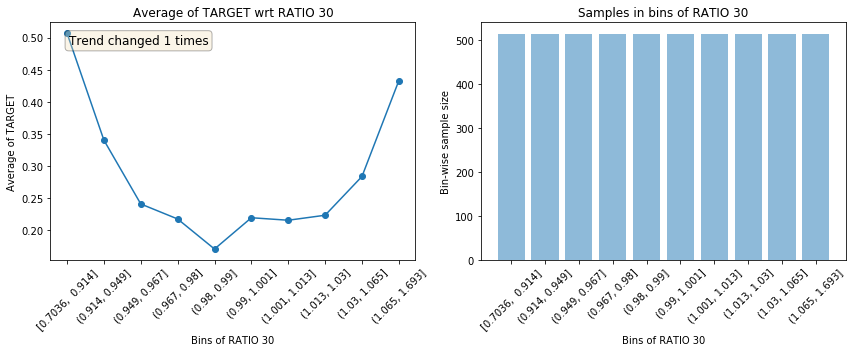

                                           Test data plots                                            


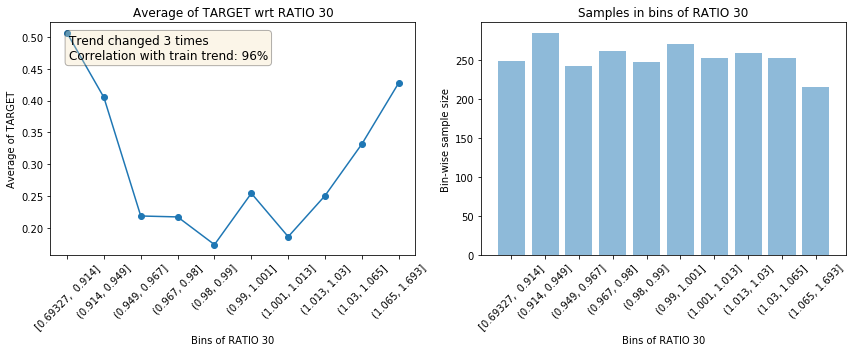

--------------------------------------------------------------------------------------------------------------


                                          Plots for RATIO 60                                          
                                           Train data plots                                           


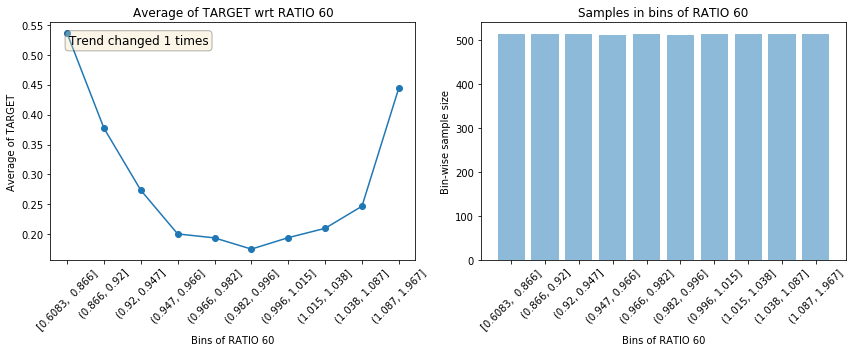

                                           Test data plots                                            


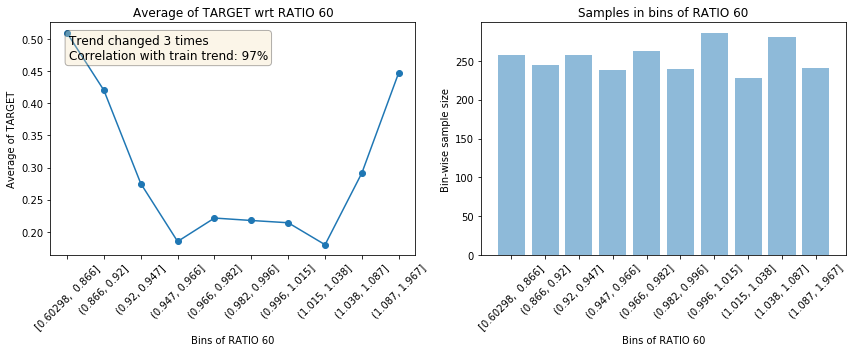

--------------------------------------------------------------------------------------------------------------


                                   Plots for AVG MONTHLY RETURN 30                                    
                                           Train data plots                                           


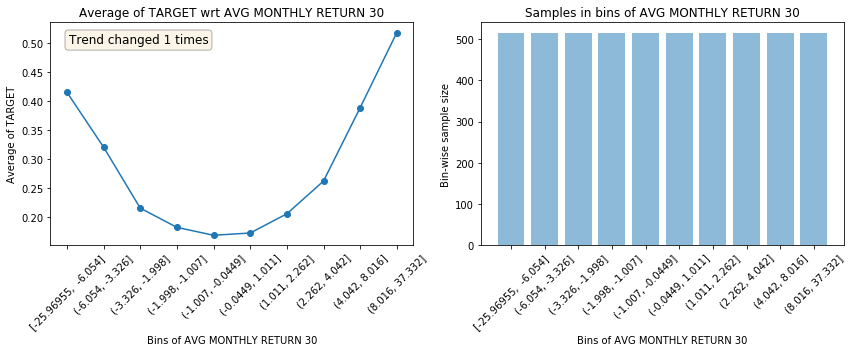

                                           Test data plots                                            


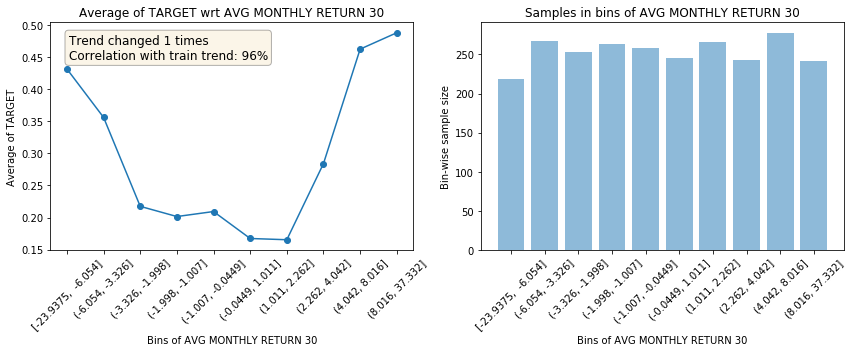

--------------------------------------------------------------------------------------------------------------


                                   Plots for AVG MONTHLY RETURN 60                                    
                                           Train data plots                                           


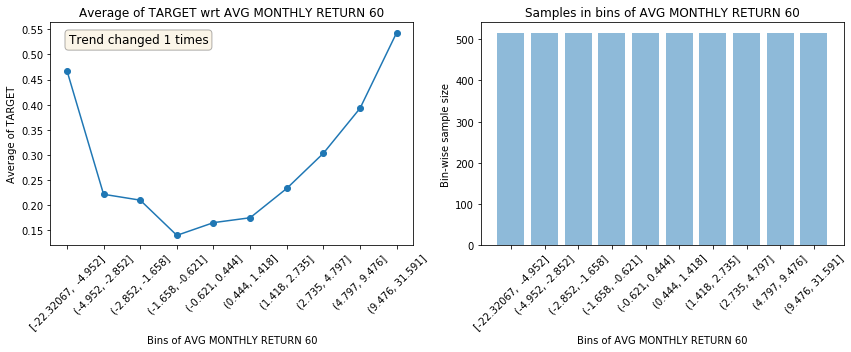

                                           Test data plots                                            


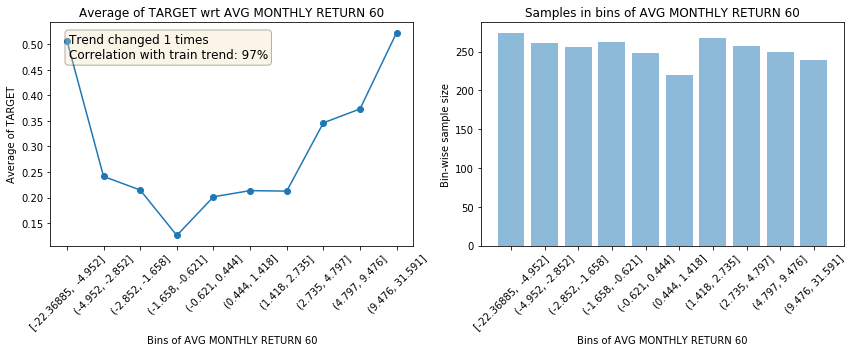

--------------------------------------------------------------------------------------------------------------


                                      Plots for MACD 10_30 DIFF                                       
                                           Train data plots                                           


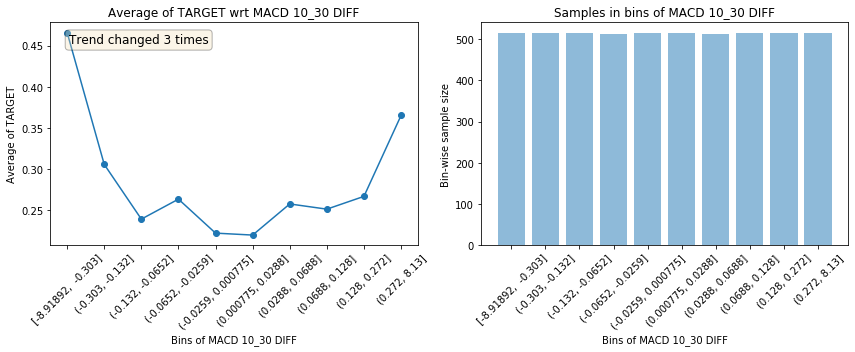

                                           Test data plots                                            


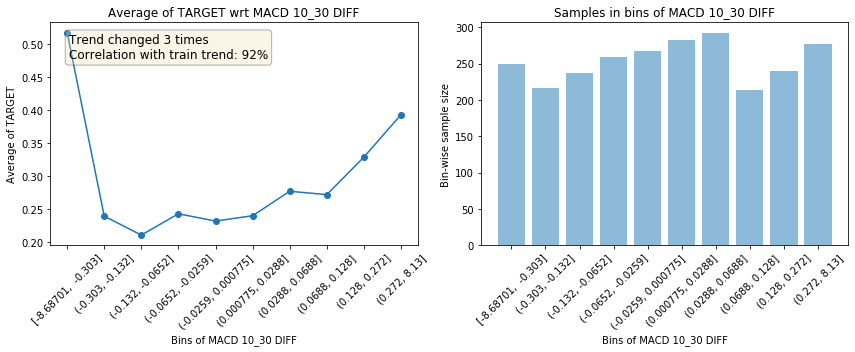

--------------------------------------------------------------------------------------------------------------


                                       Plots for MACD 5_10 DIFF                                       
                                           Train data plots                                           


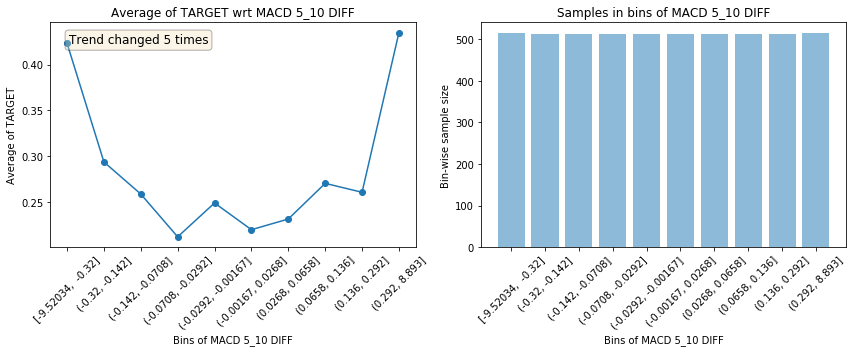

                                           Test data plots                                            


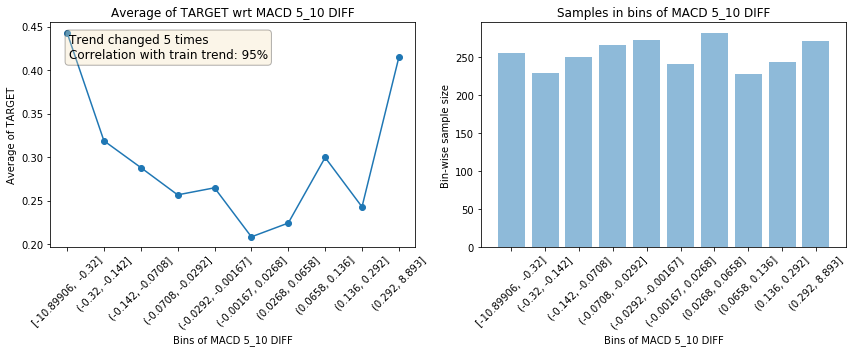

--------------------------------------------------------------------------------------------------------------


                                       Plots for MACD 2_10 DIFF                                       
                                           Train data plots                                           


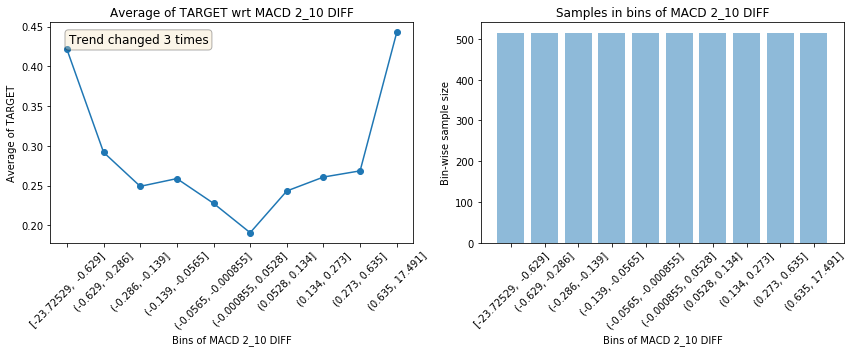

                                           Test data plots                                            


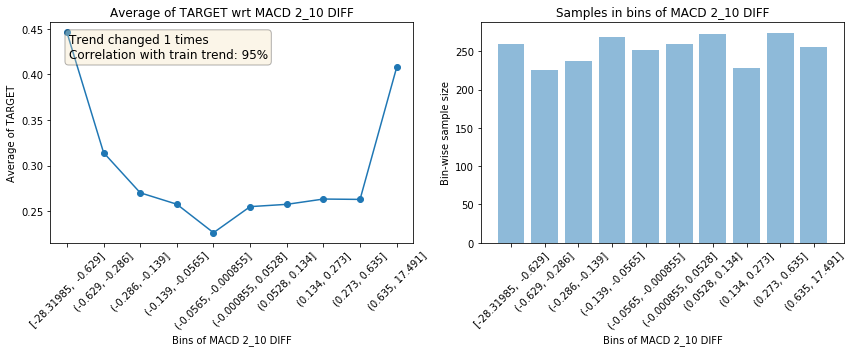

--------------------------------------------------------------------------------------------------------------


STEP THREE DONE
STEP FOUR DONE


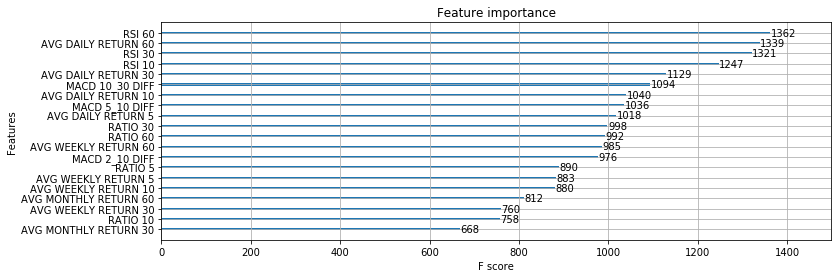

Thresh=0.039, n=20, AUC: 70.64%
Thresh=0.039, n=20, Precision: 73.98%
Thresh=0.039, n=19, AUC: 70.76%
Thresh=0.039, n=19, Precision: 72.83%
Thresh=0.042, n=18, AUC: 70.46%
Thresh=0.042, n=18, Precision: 72.71%
Thresh=0.044, n=17, AUC: 72.07%
Thresh=0.044, n=17, Precision: 75.20%
Thresh=0.045, n=16, AUC: 70.67%
Thresh=0.045, n=16, Precision: 71.24%
Thresh=0.046, n=15, AUC: 71.32%
Thresh=0.046, n=15, Precision: 74.26%
Thresh=0.047, n=14, AUC: 70.28%
Thresh=0.047, n=14, Precision: 72.08%
Thresh=0.047, n=13, AUC: 70.34%
Thresh=0.047, n=13, Precision: 72.98%
Thresh=0.047, n=12, AUC: 69.65%
Thresh=0.047, n=12, Precision: 71.43%
Thresh=0.047, n=11, AUC: 70.51%
Thresh=0.047, n=11, Precision: 70.78%
Thresh=0.048, n=10, AUC: 71.64%
Thresh=0.048, n=10, Precision: 73.28%
Thresh=0.048, n=9, AUC: 70.68%
Thresh=0.048, n=9, Precision: 70.26%
Thresh=0.049, n=8, AUC: 70.28%
Thresh=0.049, n=8, Precision: 72.08%
Thresh=0.051, n=7, AUC: 67.97%
Thresh=0.051, n=7, Precision: 67.40%
Thresh=0.051, n=6, AUC: 67

     train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0          0.839919       0.011052       0.716472      0.020346
1          0.874891       0.004405       0.751550      0.020589
2          0.890851       0.006147       0.769049      0.019923
3          0.900714       0.006324       0.776501      0.018615
4          0.906352       0.005415       0.777858      0.017175
..              ...            ...            ...           ...
319        1.000000       0.000000       0.849917      0.011771
320        1.000000       0.000000       0.849927      0.011910
321        1.000000       0.000000       0.850087      0.011989
322        1.000000       0.000000       0.850114      0.012113
323        1.000000       0.000000       0.850167      0.012203

[324 rows x 4 columns]
Ideal n_estimators:  324
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, eval_metric='auc',
              gamma=0.0, gpu_id=-1, imp

In [866]:
#'Within' testing w/ random sampling

#Getting our data, outputting to excel, getting X_train, X_test, y_train, y_test, etc.
#stock_symbols = ["KR", "WMT", "KO", "NVDA", "F", "XOM", "AMD"]
#stock_data, input_patterns, input_label = just_stock_data_within(stock_symbols, True, "WITHIN_STOCK.xlsx", 1800, 5, 10)
threshold=.85 #Rounding threshold

#If we have an excel file, use this:
stock_data = pd.read_excel("WITHIN_STOCK.xlsx", engine='openpyxl')
stock_data = stock_data.drop(['AVG MONTHLY RETURN 5','AVG MONTHLY RETURN 10'], axis=1)
stock_data = stock_data.dropna()
input_patterns = stock_data[features][60:len(stock_data)-10]
input_label = stock_data['TARGET'][60:len(stock_data)-10].astype(int) #Why are these floats? It bothers me.

X_train, X_test, y_train, y_test = train_test_split(input_patterns, input_label, test_size = .33) #Currently random splitting, look into 2yr, 1yr, 1yr of SPY
print("STEP ONE DONE")
#####################

#Baseline testing
accuracy_trials = []
recall_trials = []
precision_trials = []
auc_trials = []

for i in range(100):
    model = XGBClassifier(eval_metric="auc", use_label_encoder=False)
    model.fit(X_train, y_train)
    
    accuracy_trials.append(accuracy_score(y_test, model.predict(X_test)) * 100.0)
    precision_trials.append(precision_score(y_test, model.predict(X_test)) * 100.0)
    recall_trials.append(recall_score(y_test, model.predict(X_test)) * 100.0)
    auc_trials.append(roc_auc_score(y_test, model.predict(X_test)) * 100)

mean_accuracy = sum(accuracy_trials) / len(accuracy_trials)
mean_precision = sum(precision_trials) / len(precision_trials)
mean_recall= sum(recall_trials) / len(recall_trials)
mean_auc = sum(auc_trials) / len(auc_trials)

print("BASELINE TRIAL")
print("Mean Accuracy: {}%".format(mean_accuracy))
print("Mean Precision: {}%".format(mean_precision))
print("Mean Recall: {}%".format(mean_recall))
print("Mean AUC: {}%".format(mean_auc))

accuracy_trials = []
recall_trials = []
precision_trials = []
auc_trials = []

for i in range(100):
    model = XGBClassifier(eval_metric="auc", use_label_encoder=False)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_test)
    y_prob_round = []
    for row in y_pred:
        if row[1] > threshold:
            y_prob_round.append(1)
        else:
            y_prob_round.append(0)
    y_pred = y_prob_round    
    accuracy_trials.append(accuracy_score(y_test, y_pred) * 100.0)
    precision_trials.append(precision_score(y_test, y_pred) * 100.0)
    recall_trials.append(recall_score(y_test, y_pred) * 100.0)
    auc_trials.append(roc_auc_score(y_test, y_pred) * 100)

mean_accuracy = sum(accuracy_trials) / len(accuracy_trials)
mean_precision = sum(precision_trials) / len(precision_trials)
mean_recall= sum(recall_trials) / len(recall_trials)
mean_auc = sum(auc_trials) / len(auc_trials)

print("BASELINE TRIAL w/ THRESHOLDING")
print("Mean Accuracy: {}%".format(mean_accuracy))
print("Mean Precision: {}%".format(mean_precision))
print("Mean Recall: {}%".format(mean_recall))
print("Mean AUC: {}%".format(mean_auc))

print(model)
print("STEP TWO DONE")
#####################

#Univariate plots
X_train_full = copy.deepcopy(X_train)
X_test_full = copy.deepcopy(X_test)
X_train_full['TARGET'] = y_train
X_test_full['TARGET'] = y_test
get_univariate_plots(data=X_train_full, target_col ="TARGET", data_test=X_test_full)
print("STEP THREE DONE")
##################

#Creating new default model
model = XGBClassifier(
    learning_rate =0.1,
    n_estimators=1000,
    max_depth=5,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    objective= 'binary:logistic',
    nthread=4,
    scale_pos_weight=1,
    seed=27,
    eval_metric="auc", 
    use_label_encoder=False)
print("STEP FOUR DONE")
##################

#Extract relevant features, obtain new data w/ selected features
relevant_features(model, X_train, y_train, X_test, y_test, threshold)
selection = SelectFromModel(model, threshold=.044, prefit=True) #Could probably just turn 'prefit' off...Need to make sure getting actually correct features.
feature_bool = selection.get_support()
select_X_train = selection.transform(X_train)
select_X_test = selection.transform(X_test)
model.fit(select_X_train, y_train)
print("STEP SIX DONE")
##################

#N_estimator -> hyper_parameterization -> N_estimator again
model = n_estimator(model, select_X_train, y_train)
best_params = hyper_parameter(model, select_X_train, y_train)
model.set_params(gamma=best_params['gamma'], max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'])
model = n_estimator(model, select_X_train, y_train)
dump(model, 'rolex.joblib')
print(model)
print("STEP SEVEN DONE")
##################

#Test model on selected test data
y_pred = model.predict(select_X_test)
auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("AUC: {}".format(auc*100.0))
print("Precision: {}".format(precision*100.0))
print("Accuracy: {}".format(accuracy*100.0))

print("ROUNDING THRESHOLD OF {}".format(threshold))
y_pred = model.predict_proba(select_X_test)
y_prob_round = []
for row in y_pred:
    if row[1] > threshold:
        y_prob_round.append(1)
    else:
        y_prob_round.append(0)
y_pred = y_prob_round           
auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
print("AUC: {}".format(auc*100.0))
print("Precision: {}".format(precision*100.0))
print("Accuracy: {}".format(accuracy*100.0))
print("STEP EIGHT DONE")
##################

In [875]:
#Test model on validation data
test_stocks = ["AAPL", "X", "TGT", "INTC", "JNJ"] 
for stock in test_stocks:
    print(stock)
    stock_data_testing, input_patterns_testing, input_label_testing = just_stock_data_within([stock], False, "WITHIN_STOCK.xlsx", 1800, 5, 10)
    input_patterns_testing = input_patterns_testing.loc[:, feature_bool]
    
    accuracy_trials_testing = []
    recall_trials_testing = []
    precision_trials_testing = []
    auc_trials_testing = []

    y_pred = model.predict(input_patterns_testing.to_numpy())
    y_prob = model.predict_proba(input_patterns_testing.to_numpy())
    y_prob_round = []
    for row in y_prob:
        if row[1] > threshold:
            y_prob_round.append(1)
        else:
            y_prob_round.append(0)


    print(stock)
    print("Standard Threshold")
    print("Accuracy {}: {}%".format(stock, accuracy_score(input_label_testing, y_pred) * 100.0))
    print("Precision {}: {}%".format(stock, precision_score(input_label_testing, y_pred) * 100.0))
    print("Recall {}: {}%".format(stock, recall_score(input_label_testing, y_pred) * 100.0))
    print("AUC {}: {}%".format(stock, roc_auc_score(input_label_testing, y_pred) * 100))


    print("Rounding Threshold: {}".format(threshold))
    print("Accuracy {}: {}%".format(stock, accuracy_score(input_label_testing, y_prob_round) * 100.0))
    print("Precision {}: {}%".format(stock, precision_score(input_label_testing, y_prob_round) * 100.0))
    print("Recall {}: {}%".format(stock, recall_score(input_label_testing, y_prob_round) * 100.0))
    print("AUC {}: {}%".format(stock, roc_auc_score(input_label_testing, y_prob_round) * 100))

AAPL
AAPL
Standard Threshold
Accuracy AAPL: 69.56937799043062%
Precision AAPL: 53.431372549019606%
Recall AAPL: 32.831325301204814%
AUC AAPL: 59.75367106574968%
Rounding Threshold: 0.85
Accuracy AAPL: 69.47368421052632%
Precision AAPL: 58.0246913580247%
Recall AAPL: 14.156626506024098%
AUC AAPL: 54.69402152790684%
X
X
Standard Threshold
Accuracy X: 53.59168241965973%
Precision X: 54.94736842105263%
Recall X: 48.51301115241636%
AUC X: 53.679582499285104%
Rounding Threshold: 0.85
Accuracy X: 51.51228733459357%
Precision X: 55.41125541125541%
Recall X: 23.79182156133829%
AUC X: 51.99206462682299%
TGT
TGT
Standard Threshold
Accuracy TGT: 64.0%
Precision TGT: 29.596412556053814%
Recall TGT: 22.99651567944251%
AUC TGT: 51.209922322027936%
Rounding Threshold: 0.85
Accuracy TGT: 71.52380952380952%
Precision TGT: 41.42857142857143%
Recall TGT: 10.104529616724738%
AUC TGT: 52.36550202985648%
INTC
INTC
Standard Threshold
Accuracy INTC: 67.16417910447761%
Precision INTC: 33.093525179856115%
Recall

In [882]:
print(input_patterns.shape)

print(input_patterns.iloc[0:round(.5 * len(input_patterns))].shape)
print(input_label.iloc[0:round(.5 * len(input_label))].shape)

print(input_patterns.iloc[round(.5 * len(input_patterns)): round(.75 * len(input_patterns))].shape)
print(input_label.iloc[round(.5 * len(input_label)): round(.75 * len(input_label))].shape)

print(input_patterns.iloc[round(.75 * len(input_patterns)): len(input_patterns)].shape)
print(input_label.iloc[round(.75 * len(input_label)): len(input_label)].shape)

(7676, 20)
(3838, 20)
(3838,)
(1919, 20)
(1919,)
(1919, 20)
(1919,)


In [ ]:
def model_creation_2(stock_symbols, read_csv, export_csv, csv_name, threshold, 
                     days, percent, days_within, within):

    #Getting our data, outputting to excel, getting X_train, X_test, y_train, y_test, etc.
    if read_csv:
        stock_data = pd.read_excel(csv_name, engine='openpyxl')
        stock_data = stock_data.drop(['AVG MONTHLY RETURN 5','AVG MONTHLY RETURN 10'], axis=1)
        stock_data = stock_data.dropna()
        input_patterns = stock_data[features][60:len(stock_data)-10]
        input_label = stock_data['TARGET'][60:len(stock_data)-10].astype(int)
    else:
        if within:
            stock_data, input_patterns, input_label = just_stock_data_within(stock_symbols, export_csv, csv_name, days, percent, days_within)
        else:
            stock_data, input_patterns, input_label = just_stock_data(stock_symbols, export_csv, csv_name, days, percent, days_within)
            
    X_train, X_test, y_train, y_test = train_test_split(input_patterns, input_label, test_size = .33)
    print("STEP ONE DONE")
    #####################

    #Baseline testing
    accuracy_trials = []
    recall_trials = []
    precision_trials = []
    auc_trials = []

    for i in range(100):
        model = XGBClassifier(eval_metric="auc", use_label_encoder=False)
        model.fit(X_train, y_train)

        accuracy_trials.append(accuracy_score(y_test, model.predict(X_test)) * 100.0)
        precision_trials.append(precision_score(y_test, model.predict(X_test)) * 100.0)
        recall_trials.append(recall_score(y_test, model.predict(X_test)) * 100.0)
        auc_trials.append(roc_auc_score(y_test, model.predict(X_test)) * 100)

    mean_accuracy = sum(accuracy_trials) / len(accuracy_trials)
    mean_precision = sum(precision_trials) / len(precision_trials)
    mean_recall= sum(recall_trials) / len(recall_trials)
    mean_auc = sum(auc_trials) / len(auc_trials)

    print("BASELINE TRIAL")
    print("Mean Accuracy: {}%".format(mean_accuracy))
    print("Mean Precision: {}%".format(mean_precision))
    print("Mean Recall: {}%".format(mean_recall))
    print("Mean AUC: {}%".format(mean_auc))

    accuracy_trials = []
    recall_trials = []
    precision_trials = []
    auc_trials = []

    for i in range(100):
        model = XGBClassifier(eval_metric="auc", use_label_encoder=False)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        y_prob_round = []
        for row in y_pred:
            if row[1] > threshold:
                y_prob_round.append(1)
            else:
                y_prob_round.append(0)
        y_pred = y_prob_round    
        accuracy_trials.append(accuracy_score(y_test, y_pred) * 100.0)
        precision_trials.append(precision_score(y_test, y_pred) * 100.0)
        recall_trials.append(recall_score(y_test, y_pred) * 100.0)
        auc_trials.append(roc_auc_score(y_test, y_pred) * 100)

    mean_accuracy = sum(accuracy_trials) / len(accuracy_trials)
    mean_precision = sum(precision_trials) / len(precision_trials)
    mean_recall= sum(recall_trials) / len(recall_trials)
    mean_auc = sum(auc_trials) / len(auc_trials)

    print("BASELINE TRIAL w/ THRESHOLDING")
    print("Mean Accuracy: {}%".format(mean_accuracy))
    print("Mean Precision: {}%".format(mean_precision))
    print("Mean Recall: {}%".format(mean_recall))
    print("Mean AUC: {}%".format(mean_auc))

    print(model)
    print("STEP TWO DONE")
    #####################

    #Univariate plots
    X_train_full = copy.deepcopy(X_train)
    X_test_full = copy.deepcopy(X_test)
    X_train_full['TARGET'] = y_train
    X_test_full['TARGET'] = y_test
    get_univariate_plots(data=X_train_full, target_col ="TARGET", data_test=X_test_full)
    print("STEP THREE DONE")
    ##################

    #Creating new default model
    model = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27,
        eval_metric="auc", 
        use_label_encoder=False)
    print("STEP FOUR DONE")
    ##################

    #Extract relevant features, obtain new data w/ selected features
    relevant_features(model, X_train, y_train, X_test, y_test, threshold)
    selection = SelectFromModel(model, threshold=input("Select feature threshold: "), prefit=True) #Gotta be a better way to do this sparky FIX
    feature_bool = selection.get_support()
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    print("STEP SIX DONE")
    ##################

    #N_estimator -> hyper_parameterization -> N_estimator again
    model = n_estimator(model, select_X_train, y_train) #Should we divide into 3? Use test here and validation at the end?
    best_params = hyper_parameter(model, select_X_train, y_train)
    model.set_params(gamma=best_params['gamma'], max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'])
    model = n_estimator(model, select_X_train, y_train)
    dump(model, (input("select model name: "+'.joblib') #FIX
    print(model)
    print("STEP SEVEN DONE")
    ##################

    #Test model on selected test data
    y_pred = model.predict(select_X_test)
    auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("AUC: {}".format(auc*100.0))
    print("Precision: {}".format(precision*100.0))
    print("Accuracy: {}".format(accuracy*100.0))

    print("ROUNDING THRESHOLD OF {}".format(threshold))
    y_pred = model.predict_proba(select_X_test)
    y_prob_round = []
    for row in y_pred:
        if row[1] > threshold:
            y_prob_round.append(1)
        else:
            y_prob_round.append(0)
    y_pred = y_prob_round           
    auc = roc_auc_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    print("AUC: {}".format(auc*100.0))
    print("Precision: {}".format(precision*100.0))
    print("Accuracy: {}".format(accuracy*100.0))
    print("STEP EIGHT DONE")
    ##################
                 
    return model, X_train, y_train, X_test, y_test, select_X_train, select_X_test, stock_data, feature_bool

In [ ]:
def trials2(model, test_stocks, percent, days, days_within, within, feature_bool)
    for stock in test_stocks:
        print(stock)
        stock_data_testing = pd.DataFrame(columns=["Ticker","Date","Open","High","Low","Close"])
        y_finance_data = yf.Ticker(stock).history(start=(datetime.date.today()-datetime.timedelta(days=days)).strftime("%Y-%m-%d")).reset_index()
        y_finance_data.insert(0,"Ticker", stock)
        y_finance_data = y_finance_data[['Ticker', 'Date','Open','High','Low','Close']]

        stock_data_testing = pd.concat([stock_data_testing, y_finance_data])
        stock_data_testing = stock_data_testing.rename(columns={"Ticker":"TICKER", "Date":"DATE", "Open":"OPEN", "High":"HIGH", "Low":"LOW", "Close":"CLOSE"})
        if within:
            stock_data_testing = calcutron_within(stock_data_testing, [stock], False, None, percent, days_within)
        else:
            stock_data_testing = calcutron(stock_data_testing, [stock], False, None, percent, days_within)
        stock_data_testing = stock_data_testing.drop(['AVG MONTHLY RETURN 5','AVG MONTHLY RETURN 10'], axis=1)
        stock_data_testing = stock_data_testing.dropna()

        input_patterns_testing = stock_data_testing[features][60:len(stock_data)-10]
        input_label_testing = stock_data_testing['TARGET'][60:len(stock_data)-10].astype(int)
        input_patterns_testing = input_patterns_testing.loc[:, feature_bool]

        accuracy_trials_testing = []
        recall_trials_testing = []
        precision_trials_testing = []
        auc_trials_testing = []

        y_pred = model.predict(input_patterns_testing)
        y_prob = model.predict_proba(input_patterns_testing)
        y_prob_round = []
        for row in y_prob:
            if row[1] > threshold:
                y_prob_round.append(1)
            else:
                y_prob_round.append(0)


        print(stock)
        print("Standard Threshold")
        print("Accuracy {}: {}%".format(stock, accuracy_score(input_label_testing, y_pred) * 100.0))
        print("Precision {}: {}%".format(stock, precision_score(input_label_testing, y_pred) * 100.0))
        print("Recall {}: {}%".format(stock, recall_score(input_label_testing, y_pred) * 100.0))
        print("AUC {}: {}%".format(stock, roc_auc_score(input_label_testing, y_pred) * 100))


        print("Rounding Threshold: {}".format(threshold))
        print("Accuracy {}: {}%".format(stock, accuracy_score(input_label_testing, y_prob) * 100.0))
        print("Precision {}: {}%".format(stock, precision_score(input_label_testing, y_prob) * 100.0))
        print("Recall {}: {}%".format(stock, recall_score(input_label_testing, y_prob) * 100.0))
        print("AUC {}: {}%".format(stock, roc_auc_score(input_label_testing, y_prob) * 100))

In [ ]:
def model_creation3(stock_symbols, read_csv, export_csv, csv_name, threshold, 
                     days, percent, days_within, within):

    #Getting our data, outputting to excel, getting X_train, X_test, y_train, y_test, etc.
    if read_csv:
        stock_data = pd.read_excel(csv_name, engine='openpyxl')
        stock_data = stock_data.drop(['AVG MONTHLY RETURN 5','AVG MONTHLY RETURN 10'], axis=1)
        stock_data = stock_data.dropna()
        input_patterns = stock_data[features][60:len(stock_data)-10]
        input_label = stock_data['TARGET'][60:len(stock_data)-10].astype(int)
    else:
        if within:
            stock_data, input_patterns, input_label = just_stock_data_within(stock_symbols, export_csv, csv_name, days, percent, days_within)
        else:
            stock_data, input_patterns, input_label = just_stock_data(stock_symbols, export_csv, csv_name, days, percent, days_within)
            
    X_train = input_patterns.iloc[0:round(.5 * len(input_patterns))]
    y_train = input_label.iloc[0:(.5 * len(input_label))]
    
    X_test = input_patterns.iloc[round(.5 * len(input_patterns)): round(.75 * len(input_patterns))]
    y_test = input_label.iloc[round(.5 * len(input_label)): round(.75 * len(input_label))]
    
    X_valid = input_patterns.iloc[round(.75 * len(input_patterns)): len(input_patterns)]
    y_valid = input_label.iloc[round(.75 * len(input_label)): len(input_label)]
    
    print("STEP ONE DONE")
    #####################

    #Baseline testing
    accuracy_trials = []
    recall_trials = []
    precision_trials = []
    auc_trials = []

    for i in range(100):
        model = XGBClassifier(eval_metric="auc", use_label_encoder=False)
        model.fit(X_train, y_train)

        accuracy_trials.append(accuracy_score(y_test, model.predict(X_test)) * 100.0)
        precision_trials.append(precision_score(y_test, model.predict(X_test)) * 100.0)
        recall_trials.append(recall_score(y_test, model.predict(X_test)) * 100.0)
        auc_trials.append(roc_auc_score(y_test, model.predict(X_test)) * 100)

    mean_accuracy = sum(accuracy_trials) / len(accuracy_trials)
    mean_precision = sum(precision_trials) / len(precision_trials)
    mean_recall= sum(recall_trials) / len(recall_trials)
    mean_auc = sum(auc_trials) / len(auc_trials)

    print("BASELINE TRIAL")
    print("Mean Accuracy: {}%".format(mean_accuracy))
    print("Mean Precision: {}%".format(mean_precision))
    print("Mean Recall: {}%".format(mean_recall))
    print("Mean AUC: {}%".format(mean_auc))

    accuracy_trials = []
    recall_trials = []
    precision_trials = []
    auc_trials = []

    for i in range(100):
        model = XGBClassifier(eval_metric="auc", use_label_encoder=False)
        model.fit(X_train, y_train)
        y_pred = model.predict_proba(X_test)
        y_prob_round = []
        for row in y_pred:
            if row[1] > threshold:
                y_prob_round.append(1)
            else:
                y_prob_round.append(0)
        y_pred = y_prob_round    
        accuracy_trials.append(accuracy_score(y_test, y_pred) * 100.0)
        precision_trials.append(precision_score(y_test, y_pred) * 100.0)
        recall_trials.append(recall_score(y_test, y_pred) * 100.0)
        auc_trials.append(roc_auc_score(y_test, y_pred) * 100)

    mean_accuracy = sum(accuracy_trials) / len(accuracy_trials)
    mean_precision = sum(precision_trials) / len(precision_trials)
    mean_recall= sum(recall_trials) / len(recall_trials)
    mean_auc = sum(auc_trials) / len(auc_trials)

    print("BASELINE TRIAL w/ THRESHOLDING")
    print("Mean Accuracy: {}%".format(mean_accuracy))
    print("Mean Precision: {}%".format(mean_precision))
    print("Mean Recall: {}%".format(mean_recall))
    print("Mean AUC: {}%".format(mean_auc))

    print(model)
    print("STEP TWO DONE")
    #####################

    #Univariate plots
    X_train_full = copy.deepcopy(X_train)
    X_test_full = copy.deepcopy(X_test)
    X_train_full['TARGET'] = y_train
    X_test_full['TARGET'] = y_test
    get_univariate_plots(data=X_train_full, target_col ="TARGET", data_test=X_test_full)
    print("STEP THREE DONE")
    ##################

    #Creating new default model
    model = XGBClassifier(
        learning_rate =0.1,
        n_estimators=1000,
        max_depth=5,
        min_child_weight=1,
        gamma=0,
        subsample=0.8,
        colsample_bytree=0.8,
        objective= 'binary:logistic',
        nthread=4,
        scale_pos_weight=1,
        seed=27,
        eval_metric="auc", 
        use_label_encoder=False)
    print("STEP FOUR DONE")
    ##################

    #Extract relevant features, obtain new data w/ selected features
    relevant_features(model, X_train, y_train, X_test, y_test, threshold)
    selection = SelectFromModel(model, threshold=input("Select feature threshold: "), prefit=True) #Gotta be a better way to do this sparky FIX
    feature_bool = selection.get_support()
    select_X_train = selection.transform(X_train)
    select_X_test = selection.transform(X_test)
    select_X_valid = selection.transform(X_valid)
    model.fit(select_X_train, y_train)
    print("STEP SIX DONE")
    ##################

    #N_estimator -> hyper_parameterization -> N_estimator again
    model = n_estimator(model, select_X_test, y_test)
    best_params = hyper_parameter(model, select_X_test, y_test)
    model.set_params(gamma=best_params['gamma'], max_depth=best_params['max_depth'], min_child_weight=best_params['min_child_weight'])
    model = n_estimator(model, select_X_test, y_test)
    dump(model, (input("select model name: "+'.joblib') #FIX
    print(model)
    print("STEP SEVEN DONE")
    ##################

    #Test model on selected test data
    y_pred = model.predict(select_X_valid)
    auc = roc_auc_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    print("AUC: {}".format(auc*100.0))
    print("Precision: {}".format(precision*100.0))
    print("Accuracy: {}".format(accuracy*100.0))

    print("ROUNDING THRESHOLD OF {}".format(threshold))
    y_pred = model.predict_proba(select_X_valid)
    y_prob_round = []
    for row in y_pred:
        if row[1] > threshold:
            y_prob_round.append(1)
        else:
            y_prob_round.append(0)
    y_pred = y_prob_round           
    auc = roc_auc_score(y_valid, y_pred)
    precision = precision_score(y_valid, y_pred)
    accuracy = accuracy_score(y_valid, y_pred)
    print("AUC: {}".format(auc*100.0))
    print("Precision: {}".format(precision*100.0))
    print("Accuracy: {}".format(accuracy*100.0))
    print("STEP EIGHT DONE")
    ##################
                 
    return model, X_train, y_train, X_test, y_test, X_valid, y_valid, select_X_train, select_X_test, select_X_valid, stock_data, feature_bool

In [ ]:
stock_symbols = ["KR", "WMT", "KO", "NVDA", "F", "XOM", "AMD"]
test_stocks = ["AAPL", "X", "TGT", "INTC", "JNJ"]
read_csv = False
export_csv = True
csv_name = "WITHIN_STOCK_MULTI.xlsx"
threshold = .85
days = 10
percent = 5
days_within = 10
within = True

model, X_train, y_train, X_test, y_test, select_X_train, select_X_test, stock_data, feature_bool = model_creation_2(stock_symbols, read_csv, export_csv, csv_name, threshold, days, percent, days_within, within)
trials2(model, test_stocks, percent_increase, days, days_within, within, feature_bool)

In [ ]:
stock_symbols = ["SPY"]
read_csv = False
export_csv = True
csv_name = "WITHIN_STOCK_SPY.xlsx"
threshold = .85
days = 10
percent = 5
days_within = 10
within = True

model, X_train, y_train, X_test, y_test, select_X_train, select_X_test, stock_data, feature_bool = model_creation_3(stock_symbols, read_csv, export_csv, csv_name, threshold, days, percent, days_within, within)